In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from scipy.sparse import vstack, csr_matrix

# 加载并预处理数据
data = pd.read_csv("final_data.csv")
data['Year'] = data['Year'].astype('category')
data['Month'] = data['Month'].astype('category')
data['DayOfWeek'] = data['DayOfWeek'].astype('category')
data['Operating_Airline '] = data['Operating_Airline '].astype('category')
data['Origin'] = data['Origin'].astype('category')
data['Dest'] = data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

data = data[data['Cancelled'] != 1]
min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]
data = data.dropna(subset=['ArrDelay'])

data = data.sample(frac=0.1, random_state=42)

# 定义特征和目标
X = data.drop(columns=['DepDelay', 'ArrDelay'])
y_dep = data['DepDelay']
y_arr = data['ArrDelay']

# 确定数值和类别特征
categorical_features = X.select_dtypes(include=['category']).columns
continuous_features = X.select_dtypes(include=['float64', 'int64']).columns

# 特征预处理
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), continuous_features)
    ]
)

In [8]:
import pandas as pd

# 计算相关性
correlation = data[['DepDelay', 'ArrDelay']].corr(method='pearson')
print("DepDelay 和 ArrDelay 的相关性矩阵：")
print(correlation)

# 提取具体的相关性数值
correlation_value = correlation.loc['DepDelay', 'ArrDelay']
print(f"\nDepDelay 和 ArrDelay 的皮尔逊相关系数: {correlation_value}")

DepDelay 和 ArrDelay 的相关性矩阵：
          DepDelay  ArrDelay
DepDelay  1.000000  0.963733
ArrDelay  0.963733  1.000000

DepDelay 和 ArrDelay 的皮尔逊相关系数: 0.9637333847315935


In [7]:
# 处理大数据量的 one-hot 编码
chunk_size = 500000
X_transformed = csr_matrix((0, preprocessor.fit_transform(X.iloc[:1]).shape[1]))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row]
    X_transformed_chunk = preprocessor.transform(data_chunk)
    X_transformed = vstack([X_transformed, X_transformed_chunk])

# 分割训练集和测试集
X_train, X_test, y_dep_train, y_dep_test, y_arr_train, y_arr_test = train_test_split(
    X_transformed, y_dep, y_arr, test_size=0.2, random_state=42
)

# 构建多任务神经网络模型
input_layer = Input(shape=(X_train.shape[1],), name='input')

# 共享层
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)

# 出发延误任务的输出层
dep_output = Dense(1, name='dep_delay')(x)

# 到达延误任务的输出层
arr_output = Dense(1, name='arr_delay')(x)

# 定义多任务模型
model = Model(inputs=input_layer, outputs=[dep_output, arr_output])

# 编译模型
model.compile(optimizer='adam', 
              loss={'dep_delay': 'mse', 'arr_delay': 'mse'},
              metrics={'dep_delay': 'mae', 'arr_delay': 'mae'})

# 训练模型
history = model.fit(
    X_train,
    {'dep_delay': y_dep_train, 'arr_delay': y_arr_train},
    validation_data=(X_test, {'dep_delay': y_dep_test, 'arr_delay': y_arr_test}),
    epochs=20,
    batch_size=64
)

# 输出模型性能
print("Model training complete.")


Epoch 1/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - arr_delay_mae: 24.0167 - dep_delay_mae: 20.4870 - loss: 5122.2979 - val_arr_delay_mae: 23.1654 - val_dep_delay_mae: 19.5574 - val_loss: 4981.2251
Epoch 2/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - arr_delay_mae: 23.1687 - dep_delay_mae: 20.0004 - loss: 5015.5664 - val_arr_delay_mae: 22.7255 - val_dep_delay_mae: 18.9528 - val_loss: 4995.6377
Epoch 3/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - arr_delay_mae: 23.1473 - dep_delay_mae: 20.0065 - loss: 5001.2246 - val_arr_delay_mae: 23.5306 - val_dep_delay_mae: 20.1668 - val_loss: 4967.0479
Epoch 4/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - arr_delay_mae: 23.1349 - dep_delay_mae: 20.0050 - loss: 4922.7959 - val_arr_delay_mae: 22.9381 - val_dep_delay_mae: 19.3731 - val_loss: 4976.1606
Epoch 5/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - arr_delay_mae: 23.2959 - dep_delay_mae: 20.1785 - loss: 5115.6445 - val_arr_delay_mae: 23.4065 - val_dep_delay_mae: 19.96

11888/11888 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - arr_delay_mae: 23.1578 - dep_delay_mae: 20.2141 - loss: 4995.3555 - val_arr_delay_mae: 23.4625 - val_dep_delay_mae: 20.5093 - val_loss: 4949.5542
Epoch 36/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - arr_delay_mae: 23.1311 - dep_delay_mae: 20.1794 - loss: 4997.8979 - val_arr_delay_mae: 23.1741 - val_dep_delay_mae: 20.3676 - val_loss: 4964.0381
Epoch 37/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - arr_delay_mae: 23.0971 - dep_delay_mae: 20.1713 - loss: 5089.4663 - val_arr_delay_mae: 23.3052 - val_dep_delay_mae: 20.1862 - val_loss: 4947.9258
Epoch 38/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - arr_delay_mae: 23.0960 - dep_delay_mae: 20.1503 - loss: 5003.7114 - val_arr_delay_mae: 23.0602 - val_dep_delay_mae: 20.0930 - val_loss: 4951.5181
Epoch 39/50
11888/11888 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - arr_delay_mae: 23.1351 - dep_delay_mae: 20.1612 - loss: 5108.2905 - val_arr_delay_mae: 22.9222 - val_dep_delay_mae: 19.7560 - va

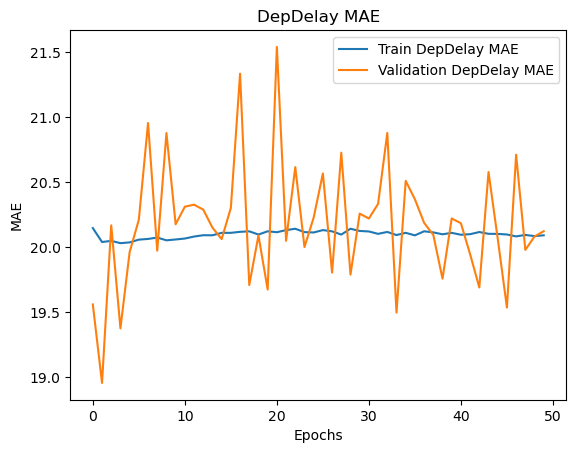

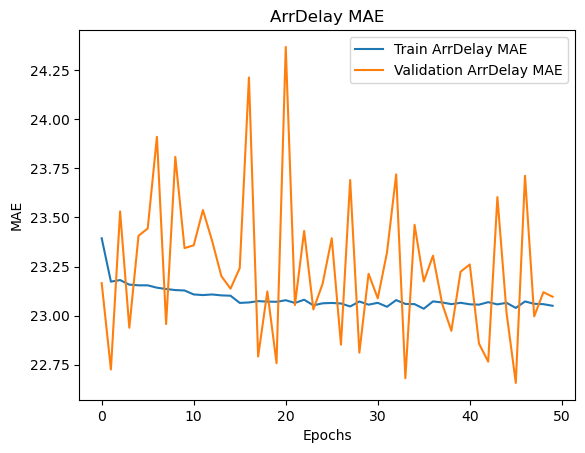

In [9]:
import matplotlib.pyplot as plt

# 绘制 DepDelay 的 MAE 曲线
plt.plot(history.history['dep_delay_mae'], label='Train DepDelay MAE')
plt.plot(history.history['val_dep_delay_mae'], label='Validation DepDelay MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('DepDelay MAE')
plt.show()

# 绘制 ArrDelay 的 MAE 曲线
plt.plot(history.history['arr_delay_mae'], label='Train ArrDelay MAE')
plt.plot(history.history['val_arr_delay_mae'], label='Validation ArrDelay MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('ArrDelay MAE')
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 获取预测值
y_dep_test_pred, y_arr_test_pred = model.predict(X_test)

# 计算 DepDelay 和 ArrDelay 的 MAE 和 MSE
dep_mae = mean_absolute_error(y_dep_test, y_dep_test_pred)
dep_mse = mean_squared_error(y_dep_test, y_dep_test_pred)
arr_mae = mean_absolute_error(y_arr_test, y_arr_test_pred)
arr_mse = mean_squared_error(y_arr_test, y_arr_test_pred)

print("Test Set Performance:")
print(f"DepDelay MAE: {dep_mae}")
print(f"DepDelay MSE: {dep_mse}")
print(f"ArrDelay MAE: {arr_mae}")
print(f"ArrDelay MSE: {arr_mse}")

5944/5944 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Test Set Performance:
DepDelay MAE: 20.121304831389544
DepDelay MSE: 2371.566386203246
ArrDelay MAE: 23.096172406601177
ArrDelay MSE: 2575.150904853533


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PowerTransformer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
data = pd.read_csv("final_data.csv")
data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

data = data[data['Cancelled'] != 1]
min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]  # Remove row with minimum ArrDelay
data = data.dropna(subset=['ArrDelay'])

In [ ]:
data = data.sample(frac=0.1, random_state=42)
# Define features and target variable
# 提取数值特征和目标变量
X = data.drop(columns=['DepDelay', 'ArrDelay'])  # 输入特征
y_dep = data['DepDelay']  # 出发延误
y_arr = data['ArrDelay']  # 到达延误

categorical_features = X.select_dtypes(include=['category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X) 

In [ ]:
from scipy.sparse import vstack, csr_matrix

chunk_size = 500000  
X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row]  

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

In [ ]:
# 划分训练集和测试集
X_train, X_test, y_dep_train, y_dep_test, y_arr_train, y_arr_test = train_test_split(
    X_scaled, y_dep, y_arr, test_size=0.2, random_state=42
)

categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(data.columns):
        numerical_feature_names.append(data.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

### 多任务

In [ ]:
# 多任务神经网络模型
input_layer = Input(shape=(X_train.shape[1],), name='input')

# 共享层
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

# 出发延误任务的输出层
dep_output = Dense(1, name='dep_delay')(x)

# 到达延误任务的输出层
arr_output = Dense(1, name='arr_delay')(x)

# 定义多任务模型
model = Model(inputs=input_layer, outputs=[dep_output, arr_output])

# 编译模型
model.compile(optimizer='adam', 
              loss={'dep_delay': 'mse', 'arr_delay': 'mse'},
              metrics={'dep_delay': 'mae', 'arr_delay': 'mae'})

# 训练模型
history = model.fit(
    X_train,
    {'dep_delay': y_dep_train, 'arr_delay': y_arr_train},
    validation_data=(X_test, {'dep_delay': y_dep_test, 'arr_delay': y_arr_test}),
    epochs=50,
    batch_size=64
)

# 输出模型性能
print("Model training complete.")